In [57]:
import warnings
warnings.filterwarnings('ignore')

In [105]:
from sklearn.pipeline import Pipeline
from scipy.stats import rankdata


from typing import List, Optional
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import statsmodels.api as sm
from tqdm import tqdm
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
import sklearn as sk
from sklearn.metrics import roc_auc_score, f1_score,r2_score,classification_report,accuracy_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
# import missingno as msno
import xgboost as xgb
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import ttest_rel
%matplotlib inline

In [59]:
TRAIN = 'course_project_train.csv'
TEST = 'course_project_test.csv'
Train_working="Train_working.csv"
Test_working ='Test_working.csv'
predict = 'VErshov_predictions.csv'
Train_work = 'Train_work.pkl'
Test_work = 'Test_work.pkl'


In [60]:
train = pd.read_csv(Train_working)
test= pd.read_csv(Test_working)
target = train['Credit Default']
with open(Train_work, 'rb') as f:
    train_work = pickle.load(f)
with open(Test_work, 'rb') as f:
    test_work = pickle.load(f)

train_ = pd.read_csv(TRAIN)    

In [61]:
# разделим признаки по типу
target_col = ['Credit Default']
categorical_features=['Home Ownership','Tax Liens','Purpose','Term']
discrete_feature = ['Years in current job','Number of Open Accounts',\
                    'Years of Credit History','Number of Credit Problems',\
                   'Months since last delinquent','Bankruptcies','Credit Score']
continuous_feature = ['Annual Income','Maximum Open Credit','Current Loan Amount',\
                      'Current Credit Balance','Monthly Debt']
len(target_col + categorical_features +  discrete_feature + continuous_feature)

17

In [6]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) :
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [7]:
def test_hold_out_val(df,target,params,n=500):
    res = pd.DataFrame()
    for j in [0.2,0.25,0.3,0.35]:
        score={}
        score['test'] = []
        score['train'] = []   
        for i in range(n):      
            x_train, x_test,y_train,y_test = train_test_split(df,target, test_size=j,\
                                                              shuffle=True, random_state=i+1)
            dtrain = lgb.Dataset(data = x_train,label=y_train)
            dvalid = lgb.Dataset(data=x_test,label=y_test)
            model_lgb  = lgb.train(
                    params=params,
                    train_set=dtrain,
                    num_boost_round=10000,
                    valid_sets=[dtrain, dvalid],
                    categorical_feature='auto',
                    verbose_eval=None,
                    early_stopping_rounds=95)
            score['train'].append(model_lgb.best_score['training']['auc'])
            score['test'].append(model_lgb.best_score['valid_1']['auc'])
        test = np.array(score['test'])
        train = np.array(score['train'])
        res.loc[j,'conf_v']=str(calculate_confidence_interval(test))
        res.loc[j,'min_v']=test.min()
        res.loc[j,'max_v']=test.max()
        res.loc[j,'delta_v']=test.max() - test.min()
        res.loc[j,'mean_v']=test.mean()
        res.loc[j,'std_v']=test.std()
        res.loc[j,'delta_mean_v_t']=train.mean()-test.mean()
        res.loc[j,'conf_t']=str(calculate_confidence_interval(train))
        res.loc[j,'min_t']=train.min()
        res.loc[j,'max_t']=train.max()
        res.loc[j,'delta_t']=train.max() - train.min()
        res.loc[j,'mean_t']=train.mean()
        res.loc[j,'std_t']=train.std()
    return res  

def test_hold_out_val_1(df,target,params,n=100):
    res = pd.DataFrame()

    score={}
    score['test'] = []
    score['valid'] = []   
    for i in range(n):      
        x_train, x_valid,y_train,y_valid = train_test_split(df,target, test_size=0.3,\
                                                              shuffle=True, random_state=i+1)
        x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=i+1)
            
            
            
            
        dtrain = lgb.Dataset(data = x_train,label=y_train)
        dvalid = lgb.Dataset(data=x_valid,label=y_valid)
        model_lgb  = lgb.train(
                    params=params_lgb,
                    train_set=dtrain,
                    num_boost_round=10000,
                    valid_sets=[dtrain, dvalid],
                    categorical_feature='auto',
                    verbose_eval=None,
                    early_stopping_rounds=95)
        a=roc_auc_score(y_test,model_lgb.predict(x_test))
        b=model_lgb.best_score['valid_1']['auc']
        score['test'].append(a)
        score['valid'].append(b)
    test = np.array(score['test'])
    valid = np.array(score['valid'])
    res.loc[0,'conf_t']=str(calculate_confidence_interval(test))
    res.loc[0,'min_t']=test.min()
    res.loc[0,'max_t']=test.max()
    res.loc[0,'delta_t']=test.max() - test.min()
    res.loc[0,'mean_t']=test.mean()
    res.loc[0,'std_t']=test.std()
    res.loc[0,'delta_mean_v_t']=valid.mean()-test.mean()
    res.loc[0,'conf_v']=str(calculate_confidence_interval(valid))
    res.loc[0,'min_v']=valid.min()
    res.loc[0,'max_v']=valid.max()
    res.loc[0,'delta_v']=valid.max() - valid.min()
    res.loc[0,'mean_v']=valid.mean()
    res.loc[0,'std_v']=valid.std()
    return res  




def test_cros_val(df,target,model,metric,n=100):
    res = pd.DataFrame()
    for j in [3,4,5,6,7,8]:
        score=[]
        std = []
 
        for i in range(n):
            cv_strategy = KFold(n_splits=j, shuffle=True, random_state=i+1)        
            rusult= make_cross_validation(df, target, model, metric,cv_strategy,print_is=False)
            
            score.append(rusult[1])
            std.append(np.array(rusult[3]).std())

        test = np.array(score)
        train = np.array(std)

        res.loc[j,'conf_of']=str(calculate_confidence_interval(test))
        res.loc[j,'min_of']=test.min()
        res.loc[j,'max_of']=test.max()
        res.loc[j,'delta_of']=test.max() - test.min()
        res.loc[j,'mean_of']=test.mean()
        res.loc[j,'std_of'] = test.std()
        res.loc[j,'conf_st']=str(calculate_confidence_interval(train))
        res.loc[j,'min_st']=train.min()
        res.loc[j,'max_st']=train.max()
        res.loc[j,'delta_st']=train.max() - train.min()
        res.loc[j,'mean_st']=train.mean()
        res.loc[j,'std_st']=train.std()
    return res
        

In [8]:
def drop_target(df,target='Credit Default'):
    return df.drop(target,axis = 1)

In [9]:
def test_for_data(        y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy: int,
                          data: list):
    p,t_stats, n_trees,off_n = [], [],[],[]
    base_score = np.array([])
    for num,i in enumerate(data):
        current_score = np.array([])
        off = []
        
        for j in range(20):
            fold = KFold(n_splits=cv_strategy, shuffle=True, random_state=j+1)
            res = make_cross_validation(i,y,estimator,metric,fold,print_is=False)
            scores = res[3]
            off.append(res[1])
            if num == 0:
                base_score = np.append(base_score, scores)
            else:
                current_score = np.append(current_score, scores)
        if num!=0:
            t_stat, p_value = ttest_rel(current_score, base_score)
            t_stats.append(t_stat)
            n_trees.append(num)
            p.append(p_value)
        off_n.append(off)

    plt.plot(n_trees, t_stats)
    plt.xlabel('data')
    plt.ylabel('t-statistic')
    return (t_stats,p),off_n
        
        
    
    

def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train, eval_set=[(x_train,y_train)],\
                      eval_metric = 'auc',verbose=None) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [10]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [11]:
train[categorical_features] =train[categorical_features].astype('category')
test[categorical_features] =test[categorical_features].astype('category')


In [12]:
train_work.keys()

dict_keys(['start', '1', '2', '3', '1-1', '1-2', '1-3', '2-1', '2-2', '2-3', '3-1', '3-2', '3-3', '4', '5', '6', '4-2', '5-2', '6-2'])

In [13]:
for i in train_work:
    a = categorical_features.copy()
    a.remove('Purpose')
    a.remove( 'Tax Liens')
    if i in ['4-2','5-2','6-2']:
        continue
    train_work[i][categorical_features] =train_work[i][categorical_features].astype('category')
    test_work[i][categorical_features] =train_work[i][categorical_features].astype('category')

In [25]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_jobs": -1,
    "seed": 27,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10    
}


In [26]:
params_lgb_sk_s = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": -1,
    "seed": 27,
    'num_boost_round':2000,
    "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}

In [27]:
params_lgb_sk = {
     "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": -1,
    "seed": 27,
    'num_boost_round':2000,
#     "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}

1. Обучение с применением отложенной выборки. Валидационная Выборка одна

In [28]:
x_train, x_test,y_train,y_test = train_test_split(train.drop(target_col[0], axis=1),target, test_size=0.2,\
                                                              shuffle=True, random_state=1)

In [29]:
x_train.shape, x_test.shape

((6000, 16), (1500, 16))

In [30]:
dtrain = lgb.Dataset(data = x_train,label=y_train)
dvalid = lgb.Dataset(data=x_test,label=y_test)

In [31]:
model = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=90,
    verbose_eval=100
)

Training until validation scores don't improve for 90 rounds
[100]	training's auc: 0.781605	valid_1's auc: 0.761305
[200]	training's auc: 0.791705	valid_1's auc: 0.764791
[300]	training's auc: 0.797587	valid_1's auc: 0.765949
[400]	training's auc: 0.803591	valid_1's auc: 0.767092
[500]	training's auc: 0.810148	valid_1's auc: 0.767749
Early stopping, best iteration is:
[478]	training's auc: 0.808676	valid_1's auc: 0.768008


п.1 но с разными рандомами

In [32]:
%%time
res_2=[]
for i in tqdm(range(100)):
   
    x_train, x_valid,y_train,y_valid = train_test_split(train,target, test_size=0.2,\
                                shuffle=True, random_state=np.random.randint(1000))
    
#     print(x_valid.shape,x_test.shape)
    
    model_1 =lgb.LGBMClassifier(**params_lgb_sk_s)
    model_1.fit(drop_target(x_train), y_train, \
          eval_set=[(drop_target(x_train), y_train),(drop_target(x_valid),y_valid)],eval_metric = 'auc',verbose=None) 
    y_test_pred = model_1.predict_proba(drop_target(x_valid))[:,1]
    res_2.append(roc_auc_score(y_valid,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]

0.7734302268061691 0.01273728610901181 0.8053183692270689 0.7408009128450337
Wall time: 58.3 s


2. Обучение без использования отложенной выборки (одна отложенная выборка)

In [33]:
model = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain],
    categorical_feature="auto",
    early_stopping_rounds=90,
    verbose_eval=None
)

In [34]:
roc_auc_score(y_test,model.predict(x_test))

0.7661374407062785

п.2 на разных рандомах

In [35]:
%%time
for i in tqdm(range(100)):
   
    x_train, x_valid,y_train,y_valid = train_test_split(train,target, test_size=0.2,\
                                                              shuffle=True, random_state=np.random.randint(1000))
    
#     print(x_valid.shape,x_test.shape)
    
    model_1 =lgb.LGBMClassifier(**params_lgb_sk_s)
    model_1.fit(drop_target(x_train), y_train, \
          eval_set=[(drop_target(x_train), y_train)],eval_metric = 'auc',verbose=None) 
    y_test_pred = model_1.predict_proba(drop_target(x_valid))[:,1]
    res_2.append(roc_auc_score(y_valid,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]

0.7745746877180087 0.011747076737498804 0.8053183692270689 0.7408009128450337
Wall time: 2min 8s


3. Обучение с мспользованием двух отложенных выборок. Первая учавствует в обучении, вторая на валидации

In [36]:
x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train),target, test_size=0.3,\
                                                              shuffle=True, random_state=100)


In [37]:
x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=100)

In [38]:
dtrain = lgb.Dataset(data = x_train,label=y_train)
dvalid = lgb.Dataset(data = x_valid,label=y_valid)

In [39]:
model = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=90,
    verbose_eval=100
)

Training until validation scores don't improve for 90 rounds
[100]	training's auc: 0.779896	valid_1's auc: 0.787121
[200]	training's auc: 0.790775	valid_1's auc: 0.791359
[300]	training's auc: 0.798359	valid_1's auc: 0.792205
[400]	training's auc: 0.804439	valid_1's auc: 0.793146
[500]	training's auc: 0.811179	valid_1's auc: 0.793758
[600]	training's auc: 0.816053	valid_1's auc: 0.793987
[700]	training's auc: 0.820474	valid_1's auc: 0.794592
[800]	training's auc: 0.824352	valid_1's auc: 0.794955
Early stopping, best iteration is:
[759]	training's auc: 0.822804	valid_1's auc: 0.795066


In [40]:
roc_auc_score(y_test,model.predict(x_test))

0.7514281132104291

п.3 на разных рандомах

In [41]:
%%time
res_2 = []
for i in tqdm(range(100)):
   
    x_train, x_valid,y_train,y_valid = train_test_split(drop_target(train),target, test_size=0.3,\
                                            shuffle=True, random_state=np.random.randint(1000))
    x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                            shuffle=True, random_state=np.random.randint(1000))
#     print(x_valid.shape,x_test.shape)

    model_1 =lgb.LGBMClassifier(**params_lgb_sk_s)
    model_1.fit(x_train, y_train, \
          eval_set=[(x_train, y_train),(x_valid,y_valid)],eval_metric = 'auc',verbose=None) 
    y_test_pred = model_1.predict_proba(x_test)[:,1]
    a = roc_auc_score(y_test,y_test_pred)
    res_2.append(a)
#     print(a,roc_auc_score(y_valid,model_1.predict_proba(x_valid)[:,1]))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]

0.7688465618798831 0.01601289601059654 0.8110023796995138 0.7241750776397515
Wall time: 51.3 s


Крос валидация

In [43]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=100)

In [44]:
params_lgb_sk_s = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": 15,
    "seed": 27,
    'num_boost_round':2000,
    "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}
model_sk=lgb.LGBMClassifier(**params_lgb_sk_s)

In [72]:
%%time
res = make_cross_validation(
    drop_target(train_work['3-3']), target, model_sk, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 6000, valid-observations = 1500
train-score = 0.843, valid-score = 0.7938
Fold: 2, train-observations = 6000, valid-observations = 1500
train-score = 0.8451, valid-score = 0.7746
Fold: 3, train-observations = 6000, valid-observations = 1500
train-score = 0.846, valid-score = 0.7812
Fold: 4, train-observations = 6000, valid-observations = 1500
train-score = 0.8482, valid-score = 0.7792
Fold: 5, train-observations = 6000, valid-observations = 1500
train-score = 0.847, valid-score = 0.7566
CV-results train: 0.8459 +/- 0.002
CV-results valid: 0.7771 +/- 0.012
OOF-score = 0.7764
Wall time: 5.59 s


Крос валидация на разных рандомах

In [54]:
%%time
n = 100
res_all=[]
for i in tqdm(range(n)):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    res = make_cross_validation(
    drop_target(train_work['3-3']), target, model_sk, metric=roc_auc_score,\
        cv_strategy=fold,print_is=False
            )
    res_all.append(res[1])
a = np.array(res_all) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:12<00:00,  6.73s/it]

0.7735865566883728 0.001751720016253073 0.777263558279643 0.7676363431587728
Wall time: 11min 12s


<BarContainer object of 16 artists>

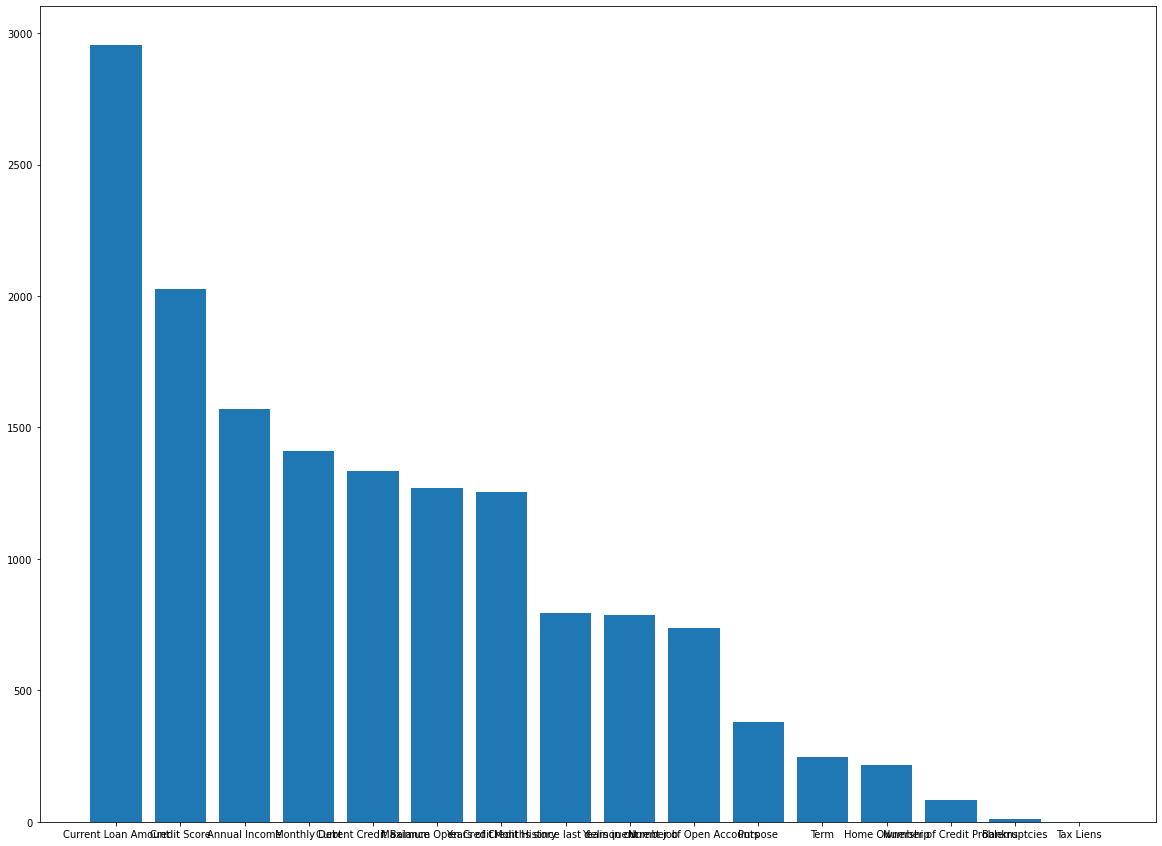

In [51]:
model_sk.feature_importances_
d = list(zip(test.columns.to_list(),model_sk.feature_importances_))
x = list(map(lambda x:x[0],(sorted(d,key = lambda x: x[1],reverse=True))))
y = list(map(lambda x:x[1],(sorted(d,key = lambda x: x[1],reverse=True))))
fig = plt.figure(figsize=(20,15))
plt.bar(x,y)


In [52]:
importance = x[:-3]
importance

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Monthly Debt',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Years of Credit History',
 'Months since last delinquent',
 'Years in current job',
 'Number of Open Accounts',
 'Purpose',
 'Term',
 'Home Ownership']

Сравним наоры данных по фолдам крос валидации

In [55]:
%%time
base_score = np.array([])
model = lgb.LGBMClassifier(**params_lgb_sk)

for i in range(50):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores = cross_val_score(
        estimator=model_sk,
        X=drop_target(train),
        y=target,
        scoring='roc_auc',
        cv=fold
    )
    print(scores)
    base_score = np.append(base_score, scores)

[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan n

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [34:09<00:00, 107.85s/it]

Wall time: 34min 9s


Text(0, 0.5, 't-statistic')

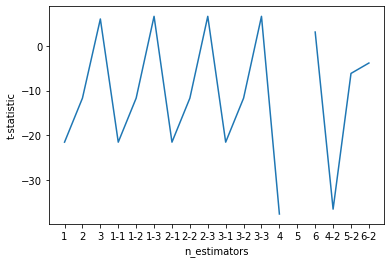

In [605]:
%%time
d = []

for n,i in train_work.items():
    k=i.copy()    

    d.append((n,k))
t_stats, n_trees = [], []
j = 1
for data in tqdm(d):
    current_score = np.array([])
    for i in range(50):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_val_score(
            estimator=model_sk,
            X=drop_target(data[1]),
            y=target,
            scoring='roc_auc',
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = ttest_rel(current_score, base_score)
    t_stats.append(t_stat)
    n_trees.append(data[0])

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

In [606]:
t_stats

[nan,
 -21.502223037636462,
 -11.662904897783804,
 6.042819352378845,
 -21.502223037636462,
 -11.662904897783804,
 6.631920759724058,
 -21.502223037636462,
 -11.662904897783804,
 6.631920759724058,
 -21.502223037636462,
 -11.662904897783804,
 6.631920759724058,
 -37.57141337175088,
 nan,
 3.1217209255351,
 -36.48132052075534,
 -6.131475587862104,
 -3.8083082028819852]

In [607]:
n_trees

['start',
 '1',
 '2',
 '3',
 '1-1',
 '1-2',
 '1-3',
 '2-1',
 '2-2',
 '2-3',
 '3-1',
 '3-2',
 '3-3',
 '4',
 '5',
 '6',
 '4-2',
 '5-2',
 '6-2']

Балансировка признаков

In [323]:
x_train, x_valid,y_train,y_valid = train_test_split(train,target, test_size=0.3,\
                                                              shuffle=True, random_state=89)


In [324]:
x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=89)

In [325]:
train_balanced = balance_df_by_target(x_train, target_col[0])


In [326]:
target_balanced = train_balanced[target_col[0]]

In [327]:
res_ = make_cross_validation(
    drop_target(train_balanced), target_balanced, model_sk, metric=roc_auc_score, cv_strategy=cv_strategy
            )

Fold: 1, train-observations = 5353, valid-observations = 1339
train-score = 0.853, valid-score = 0.8131
Fold: 2, train-observations = 5353, valid-observations = 1339
train-score = 0.8546, valid-score = 0.7944
Fold: 3, train-observations = 5354, valid-observations = 1338
train-score = 0.8517, valid-score = 0.7906
Fold: 4, train-observations = 5354, valid-observations = 1338
train-score = 0.8511, valid-score = 0.7991
Fold: 5, train-observations = 5354, valid-observations = 1338
train-score = 0.8522, valid-score = 0.7913
CV-results train: 0.8525 +/- 0.001
CV-results valid: 0.7977 +/- 0.008
OOF-score = 0.7974


Обучим на сбалансированной, с учетом валидации первой отложенной выборки и контроля на второй отложенной выборке

In [328]:
model_sk.fit(drop_target(train_balanced), target_balanced, \
          eval_set=[(drop_target(train_balanced), target_balanced),(drop_target(x_valid),y_valid)],eval_metric = 'auc',verbose=None) 

LGBMClassifier(early_stopping_rounds=90, learning_rate=0.05, max_depth=4,
               metric='auc', min_child_samples=30, n_jobs=15,
               num_boost_round=2000, objective='binary', reg_alpha=10,
               reg_lambda=500, seed=27)

In [329]:
model_sk.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8253015405191203)]),
             'valid_1': OrderedDict([('auc', 0.7596420372090881)])})

In [330]:
y_test_pred = model_sk.predict_proba(drop_target(x_test))[:,1]

In [331]:
roc_auc_score(y_test,y_test_pred)

0.7809698996655519

In [334]:
%%time
res_2 = []
for i in tqdm( range(100)):
   
    x_train, x_valid,y_train,y_valid = train_test_split(train,target, test_size=0.3,\
                                                              shuffle=True, random_state=np.random.randint(1000))
    x_valid, x_test,y_valid,y_test = train_test_split(x_valid,y_valid, test_size=0.5,\
                                                              shuffle=True, random_state=np.random.randint(1000))
#     print(x_valid.shape,x_test.shape)
    train_balanced = balance_df_by_target(x_train, target_col[0])
    target_balanced = train_balanced[target_col[0]]
    model_1 =lgb.LGBMClassifier(**params_lgb_sk_s)
    model_1.fit(drop_target(train_balanced), target_balanced, \
          eval_set=[(drop_target(train_balanced), target_balanced),\
                    (drop_target(x_valid),y_valid)],eval_metric = 'auc',verbose=None) 
    y_test_pred = model_1.predict_proba(drop_target(x_test))[:,1]
    res_2.append(roc_auc_score(y_test,y_test_pred))
#     print(res_2[-1])
#     print(model_1.best_score_)
a = np.array(res_2) 
print('='*60)
print(a.mean(),a.std(),a.max(),a.min())
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03it/s]

0.7680941752328302 0.016173995654417454 0.8132205879013148 0.7315355483131148
Wall time: 49.2 s


Adversarial validation

In [335]:
a = drop_target(train)
b = test.copy()

x_adv = pd.concat([
    a, b], axis=0
)
y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]
x_adv = x_adv.reset_index(drop=True)
x_adv[categorical_features]=x_adv[categorical_features].astype('category')

In [336]:
p = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 10,
    "n_jobs": 15,
    "seed": 28,
    'num_boost_round':1000,
#     "early_stopping_rounds":90, 
    'reg_alpha': 7,
    'reg_lambda': 10,
    'max_depth': 4,
    'min_child_samples':60,
#     'min_split_gain':1
#     'categorical_feature':categorical_features,
}

In [337]:
m = lgb.LGBMClassifier(**p)

In [338]:
m.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_samples': 60,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 10,
 'n_jobs': 15,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 7,
 'reg_lambda': 10,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'seed': 28,
 'num_boost_round': 1000}

In [339]:
m.fit(x_adv,y_adv,eval_set=[(x_adv, y_adv)],eval_metric = 'auc',verbose=None)

LGBMClassifier(learning_rate=0.05, max_depth=4, metric='auc',
               min_child_samples=60, n_estimators=10, n_jobs=15,
               num_boost_round=1000, objective='binary', reg_alpha=7,
               reg_lambda=10, seed=28)

In [340]:
m.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.8352532266666667)])})

In [341]:
y_pred_adv = m.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.8353


In [342]:
y_pred = m.predict_proba(drop_target(train))

In [343]:
y_pred=y_pred[:, 1]
y_pred

array([0.12760852, 0.29923465, 0.2137849 , ..., 0.2875651 , 0.08428465,
       0.18514615])

In [344]:
pd.cut(
    y_pred, bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]      91
(0.1, 0.2]    2938
(0.2, 0.3]    3477
(0.3, 0.4]     894
(0.4, 0.5]      96
(0.5, 0.6]       4
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
dtype: int64

In [345]:
idx_val= np.where(y_pred>0.3)
idx_tr = np.where(y_pred<=0.3)

In [346]:
X_valid = train.loc[idx_val]
X_train = train.loc[idx_tr]

Y_valid = X_valid[target_col[0]]
Y_train = X_train[target_col[0]]

X_valid = drop_target(train.loc[idx_val])
X_train = drop_target(train.loc[idx_tr])


In [861]:
# model_sk = lgb.LGBMClassifier(**p)

In [347]:
model_sk.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_valid,Y_valid)],eval_metric = 'auc',verbose=None)

LGBMClassifier(early_stopping_rounds=90, learning_rate=0.05, max_depth=4,
               metric='auc', min_child_samples=30, n_jobs=15,
               num_boost_round=2000, objective='binary', reg_alpha=10,
               reg_lambda=500, seed=27)

In [348]:
model_sk.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.8064591700133869)]),
             'valid_1': OrderedDict([('auc', 0.7920792079207921)])})

In [349]:
roc_auc_score(Y_valid,model_sk.predict_proba(X_valid)[0:,1])

0.7920792079207921

In [350]:
model_sk.fit(X_train,Y_train,eval_set=[(X_train,Y_train)],eval_metric = 'auc',verbose=None)

LGBMClassifier(early_stopping_rounds=90, learning_rate=0.05, max_depth=4,
               metric='auc', min_child_samples=30, n_jobs=15,
               num_boost_round=2000, objective='binary', reg_alpha=10,
               reg_lambda=500, seed=27)

In [351]:
model_sk.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.8291914745227998)])})

In [352]:
roc_auc_score(Y_valid,model_sk.predict_proba(X_valid)[0:,1])

0.7906598524461703

In [353]:
X_valid.shape

(994, 16)

In [62]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [63]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [64]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [65]:
def get_best_split(pred,y_test):
    d = {}
    for i in np.arange(0.05,0.96,0.01):
        z = np.where(pred < i, 0, 1)
        d[i] = f1_score(y_test,z)
    return sorted(d, key=d.get, reverse=True)[0]
    

In [73]:
model_sk_1= lgb.LGBMClassifier(**params_lgb_sk)

In [74]:
model_sk_1.fit(drop_target(train_work['3-3']),target)

LGBMClassifier(learning_rate=0.05, max_depth=4, metric='auc',
               min_child_samples=10, num_boost_round=2000, num_leaves=10,
               objective='binary', reg_alpha=2, reg_lambda=460, seed=27)

In [75]:
y_train_pred= model_sk_1.predict_proba(drop_target(train_work['3-3']))[:,1]

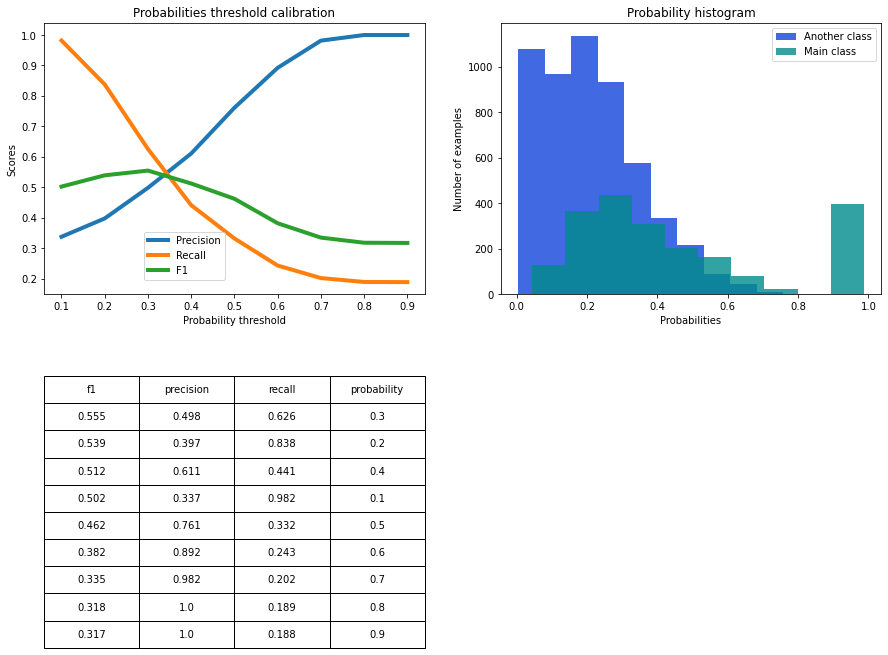

In [76]:
show_proba_calibration_plots(res[4], target)

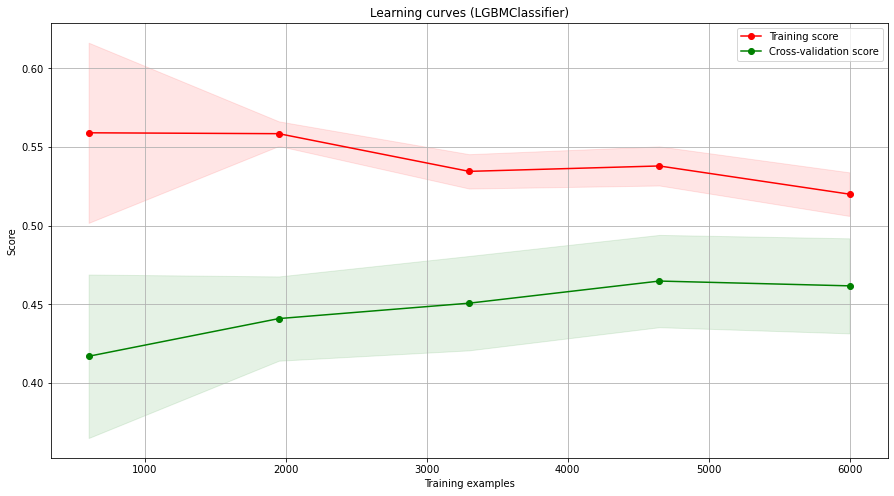

In [77]:
show_learning_curve_plot(model_sk_1, drop_target(train_work['3-3']), target, cv=5, n_jobs=-1)

In [78]:
bs = get_best_split(res[4], target)
bs

0.27

In [95]:
y_train_pred=np.where(y_train_pred<0.35,0,1)
y_test_pred = np.where(res[4]<0.35,0,1)

In [96]:
get_classification_report(target, y_train_pred, target, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      5387
           1       0.52      0.78      0.63      2113

    accuracy                           0.74      7500
   macro avg       0.71      0.75      0.71      7500
weighted avg       0.79      0.74      0.75      7500

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      5387
           1       0.55      0.52      0.53      2113

    accuracy                           0.74      7500
   macro avg       0.68      0.68      0.68      7500
weighted avg       0.74      0.74      0.74      7500

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               4486   901
1               1013  1100


In [676]:
x_train = drop_target(train_work['3-3']).copy()

In [681]:
x_train['Current Loan Amount'] = rankdata(x_train['Current Loan Amount'])

In [682]:
x_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,2.560000,482087.0,999.0,0.0,11.0,26.3,685960.0,1.0,999.0,1.0,22.053333,17.293333,7065.5,47386.0,7914.0,5353.0
1,2.560000,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,999.0,0.0,22.053333,10.880000,3277.0,394972.0,18373.0,3592.5
2,12.213333,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,999.0,0.0,22.053333,17.293333,7065.5,308389.0,13651.0,4336.0
3,2.560000,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,999.0,1.0,22.053333,17.293333,914.5,95855.0,11338.0,841.0
4,13.373333,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,999.0,0.0,22.053333,17.293333,964.0,93309.0,7180.0,1935.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,13.373333,402192.0,0.0,0.0,3.0,8.5,107866.0,0.0,999.0,0.0,2.626667,17.293333,996.5,73492.0,1900.0,917.5
7496,12.213333,1533984.0,1.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,22.053333,10.880000,5214.0,456399.0,12783.0,7460.5
7497,13.373333,1878910.0,6.0,0.0,12.0,32.1,1778920.0,0.0,999.0,0.0,0.320000,17.293333,7065.5,477812.0,12479.0,5238.0
7498,12.213333,999.0,999.0,0.0,21.0,26.5,1141250.0,0.0,999.0,0.0,22.053333,17.293333,6094.0,476064.0,37118.0,6322.0


In [683]:
params_lgb_sk_s = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": 15,
    "seed": 27,
    'num_boost_round':2000,
#     "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}
model_sk=lgb.LGBMClassifier(**params_lgb_sk_s)

In [97]:
def make_cross_validation_cb(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,print_is = True):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train) 

        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if print_is:
            print(msg)
            print("="*69)
        estimators.append(estimator)
    oof_score = metric(y, oof_predictions)
    if print_is:
        print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
        print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
        print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions   

In [702]:
x_train[categorical_features]=x_train[categorical_features].astype('str')

Fold: 1, train-observations = 6000, valid-observations = 1500
train-score = 0.8575, valid-score = 0.7806
Fold: 2, train-observations = 6000, valid-observations = 1500
train-score = 0.8582, valid-score = 0.7775
Fold: 3, train-observations = 6000, valid-observations = 1500
train-score = 0.8509, valid-score = 0.7849
Fold: 4, train-observations = 6000, valid-observations = 1500
train-score = 0.8589, valid-score = 0.7818
Fold: 5, train-observations = 6000, valid-observations = 1500
train-score = 0.8591, valid-score = 0.7606
CV-results train: 0.8569 +/- 0.003
CV-results valid: 0.7771 +/- 0.009
OOF-score = 0.7766
Wall time: 5.01 s


In [126]:
params_lgb_sk = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "n_estimators": 100,
    "n_jobs": 15,
    "seed": 27,
    'num_boost_round':2000,
#     "early_stopping_rounds":90,
    'reg_alpha': 2,
    'reg_lambda': 460,
    'max_depth': 4,
    'min_child_samples':10,
    'num_leaves':10

}
model_lgb=lgb.LGBMClassifier(**params_lgb_sk)

In [128]:
param_cb = {
    "n_estimators": 800,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "thread_count": -1,
    "early_stopping_rounds": 90,
    'custom_metric':  ['AUC'],
#     'cat_features' : categorical_features,
    "verbose": False,
    "random_seed": 42,
    "max_bin": 30,
    'learning_rate':0.05,
    "max_depth": 2,
    "l2_leaf_reg": 28, 
#     'random_strength':150,
#     'bagging_temperature':500,
    
    
    
    }
model_cb = cb.CatBoostClassifier(**param_cb)   

In [106]:
params_xgb = {'booster': 'gbtree', 
           'n_estimators': 135,
           "objective": "binary:logistic",   
           'nthread': -1,
           'seed': 28, 
           'learning_rate': 0.05,
            "eval_metric": "auc",
           'max_depth': 4, 
           'reg_lambda': 3, 
           'min_child_weight': 3,
           'gamma':0 }

model_xgb=xgb.XGBClassifier(**params_xgb)

In [112]:
X_train = drop_target(train_work['3-3'])

In [113]:
%%time
base_score = np.array([])


for i in range(50):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores = cross_val_score(
        estimator=model_xgb,
        X=X_train,
        y=target,
        scoring='roc_auc',
        cv=fold)
                
    print(scores)
    base_score = np.append(base_score, scores)

[0.76821139 0.77524341 0.78683806 0.76921169 0.76284382]
[0.76713289 0.75894401 0.75401822 0.78737833 0.78284187]
[0.7506109  0.77713354 0.76223083 0.80250079 0.78689085]
[0.77426878 0.76823063 0.74522825 0.79641629 0.78356884]
[0.77624696 0.74285899 0.78692236 0.77291446 0.78254693]
[0.7828888  0.77595174 0.77951142 0.75425909 0.77786008]
[0.78344772 0.7720265  0.76205571 0.7804451  0.77299305]
[0.77460295 0.77953815 0.76522169 0.78026545 0.76411919]
[0.7757166  0.77965508 0.76230358 0.77457775 0.77720805]
[0.77508004 0.76733303 0.79582793 0.75782947 0.76986923]
[0.78077243 0.77073932 0.75731687 0.79015595 0.7661042 ]
[0.75648098 0.77883979 0.78323674 0.78678566 0.75346338]
[0.77007734 0.75342362 0.77363269 0.7833817  0.77409445]
[0.78577395 0.7645219  0.78295035 0.77425034 0.75708798]
[0.76527128 0.75884302 0.77027092 0.76801088 0.78417687]
[0.78574723 0.76819157 0.74756591 0.77320066 0.79257098]
[0.77455978 0.76072499 0.75253407 0.78247332 0.78164529]
[0.78859931 0.76922523 0.757097

In [129]:
cross_val_score(
            estimator=model_cb,
            X=X_train,
            y=target,
            scoring='roc_auc',
            cv=fold,
            n_jobs=-1
        )

array([0.78228434, 0.78887847, 0.7687223 , 0.76431753, 0.77609683])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:18<00:00, 129.42s/it]

Wall time: 4min 18s


Text(0, 0.5, 't-statistic')

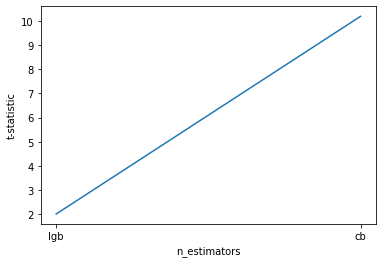

In [130]:
%%time
t_stats, n_trees = [], []
for model in tqdm([(model_lgb,'lgb'),(model_cb,'cb')]):  
    current_score = np.array([])
    for i in range(50):
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores = cross_val_score(
            estimator=model[0],
            X=X_train,
            y=target,
            scoring='roc_auc',
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = ttest_rel(current_score, base_score)
    t_stats.append(t_stat)
    n_trees.append(model[1])

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

In [131]:
t_stats

[2.015330402328223, 10.189795532745935]

In [132]:
n_trees

['lgb', 'cb']